In [19]:
%%HTML

<style type="text/css">

div.h2 {
    background-color: #665191; 
    color: white; 
    padding: 5px; 
    padding-right: 300px; 
    font-size: 25px;  
    margin-top: 2px;
    margin-bottom: 10px;
}

div.h3 {
    background-color: white; 
    color: #fe0000; 
    padding: 5px; 
    padding-right: 300px; 
    font-size: 20px; 
    margin-top: 2px;
    margin-bottom: 10px;
}
</style>

---

### <div class="h2">Introduction</div>

This is an Exploratory Data Analysis for the `Tabular Playground Series - May 2022` challenge. I will be using SHAP, Matplotlib and Seaborn to examine the data.

The data features are simulated manufacturing data that is to be used to predict the binary state (target) of the machine which is `0/1`. The motivation is not onlt to predict the state of the machine given the simulated features but to also discover the 'hidden' feature interaction that may help to improve the prediction accuracy.

Other than that, the data description page states that the data includes normalized continuous data and categorical data.

   <a id="toc"></a>
   
1. [Data Overview](#1)
2. [Analysing Interactions with SHAP](#2)
3. [References](#3)

I will keep adding content; its work in progress.

In [ ]:
!pip uninstall matplotlib -y
!pip install matplotlib==3.1.3

import matplotlib
print(matplotlib.__version__)

!pip install mplcyberpunk
import mplcyberpunk

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib 
from matplotlib import gridspec
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score, train_test_split
import shap
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
plt.style.use("cyberpunk")

# runtime configuration of matplotlib
plt.rc("figure", 
    autolayout=False, 
    figsize=(20, 10),
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=20,
    titlepad=10,
)

---
<a id="1"></a>
### <div class="h2">1. Data Overview</div>

Since there are a few extensive and insightful EDA for this competition I will keep it to an overview here, see below. There are 31 features with no missing values. I will perform feature engineering so the total number of featutres going into the final model will be different.

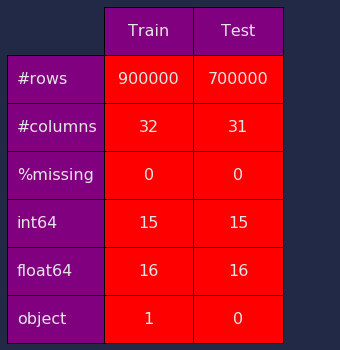

In [8]:
train_raw = pd.read_csv('../input/tabular-playground-series-may-2022/train.csv',index_col='id')
#test_raw = pd.read_csv('../input/tabular-playground-series-may-2022/test.csv',index_col='id')

#create table
fig = plt.figure(figsize=(5, 2))
ax = fig.add_subplot(111)

table_vals = [[900000, 700000], [32, 31], [0, 0], [15, 15], [16, 16], [1, 0]]

# Draw table
the_table = plt.table(cellText=table_vals,
                      colWidths=[0.08]*2,
                      rowLabels=['#rows', '#columns', '%missing', "int64", "float64", "object"],
                      colLabels=['Train', 'Test'],
                      loc='center',
                      cellLoc='center',
                      rowColours =["purple"] * 6,  
                      colColours =["purple"] * 6,
                      cellColours=[['r', 'r'], ['r', 'r'], ['r', 'r'], ['r', 'r'], ['r', 'r'], ['r', 'r']]
                      )
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)
the_table.scale(4, 4)
ax.grid(False)
ax.axis('tight')
ax.axis('off')
plt.show()

<a id="2"></a>
### <div class="h2">2. Analysing Interactions with SHAP</div>

**2.1 Modelling**

To use the SHAP package we first need to train a model since SHAP is a model agnostic approach designed to explain any given black-box model. If you are applying SHAP to a real-world problem you should follow best practices. Specifically, you should ensure your model performs well on both a training and validation set. The better your model the more reliable your results will be. As a quick check on this model, I have calculated the `AUC` of the validation set which `99%`. The model should be fine to demonstrate the SHAP package.




In [9]:
# From https://www.kaggle.com/ambrosm/tpsmay22-eda-which-makes-sense
for i in range(10):
    train_raw[f'ch{i}'] = train_raw.f_27.str.get(i).apply(ord) - ord('A')
    train_raw["unique_characters"] = train_raw.f_27.apply(lambda s: len(set(s)))

features = [col for col in train_raw.columns if col != "target" and col !="f_27"]
X=train_raw[features]
y=train_raw["target"]
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.4, random_state = 42)

# Train model
lgbm_model =LGBMClassifier(n_estimators=5000, min_child_samples=80, random_state=1307)
lgbm_model.fit(X_train.values, y_train)
y_val_pred = lgbm_model.predict_proba(X_val.values)[:,1]
score = roc_auc_score(y_val, y_val_pred)
print(f"Validation AUC:{(score):.3f}")


Validation AUC:0.990


**2.2 SHAP**

`SHAP values` are used to explain individual predictions made by a model. It does this by giving the contributions of each factor to the final prediction. `SHAP interaction` values extend on this by breaking down the contributions into their main and interaction effects. We can use these to highlight and visualise interactions in data. It can also be a useful tool to understand how your model makes predictions.

The focus will be on applying the SHAP package and interpreting the results. Specifically, we start by explaining what SHAP interaction values are and how they can be used to explain individual predictions. We then dive into different aggregations of these values which help us explain how the model makes predictions in general. This includes taking the absolute mean across all interaction values and using the SHAP summary and dependence plot.

In [10]:
# Using a random sample of the dataframe for better time computation
X_sampled = X_val.sample(20000, random_state=1307)

# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_sampled)

#Get SHAP interaction values. Beware it is time consuming to calculate the interaction values.
#shap_interaction = explainer.shap_interaction_values(X_sampled)
#print(np.shape(shap_interaction))

loaded_arr = np.loadtxt('../input/shap-interaction/shap_interaction_20k.txt')
load_original_arr = loaded_arr.reshape(
    #loaded_arr.shape[0], loaded_arr.shape[1] // shap_interaction.shape[2], shap_interaction.shape[2])
    loaded_arr.shape[0], loaded_arr.shape[1] // 41, 41)

shap_interaction = load_original_arr

**Step1: Absolute mean plot**

Individual contribution matrices allows us to explain individual model predictions at `local` level. But what if we want to explain how the model makes predictions at a `global` level? To do this we can aggregate the values in the contribution matrices by taking the absolute mean. Presenting the results in a heatmap can be effective to highlight important main effects and interaction effects. 

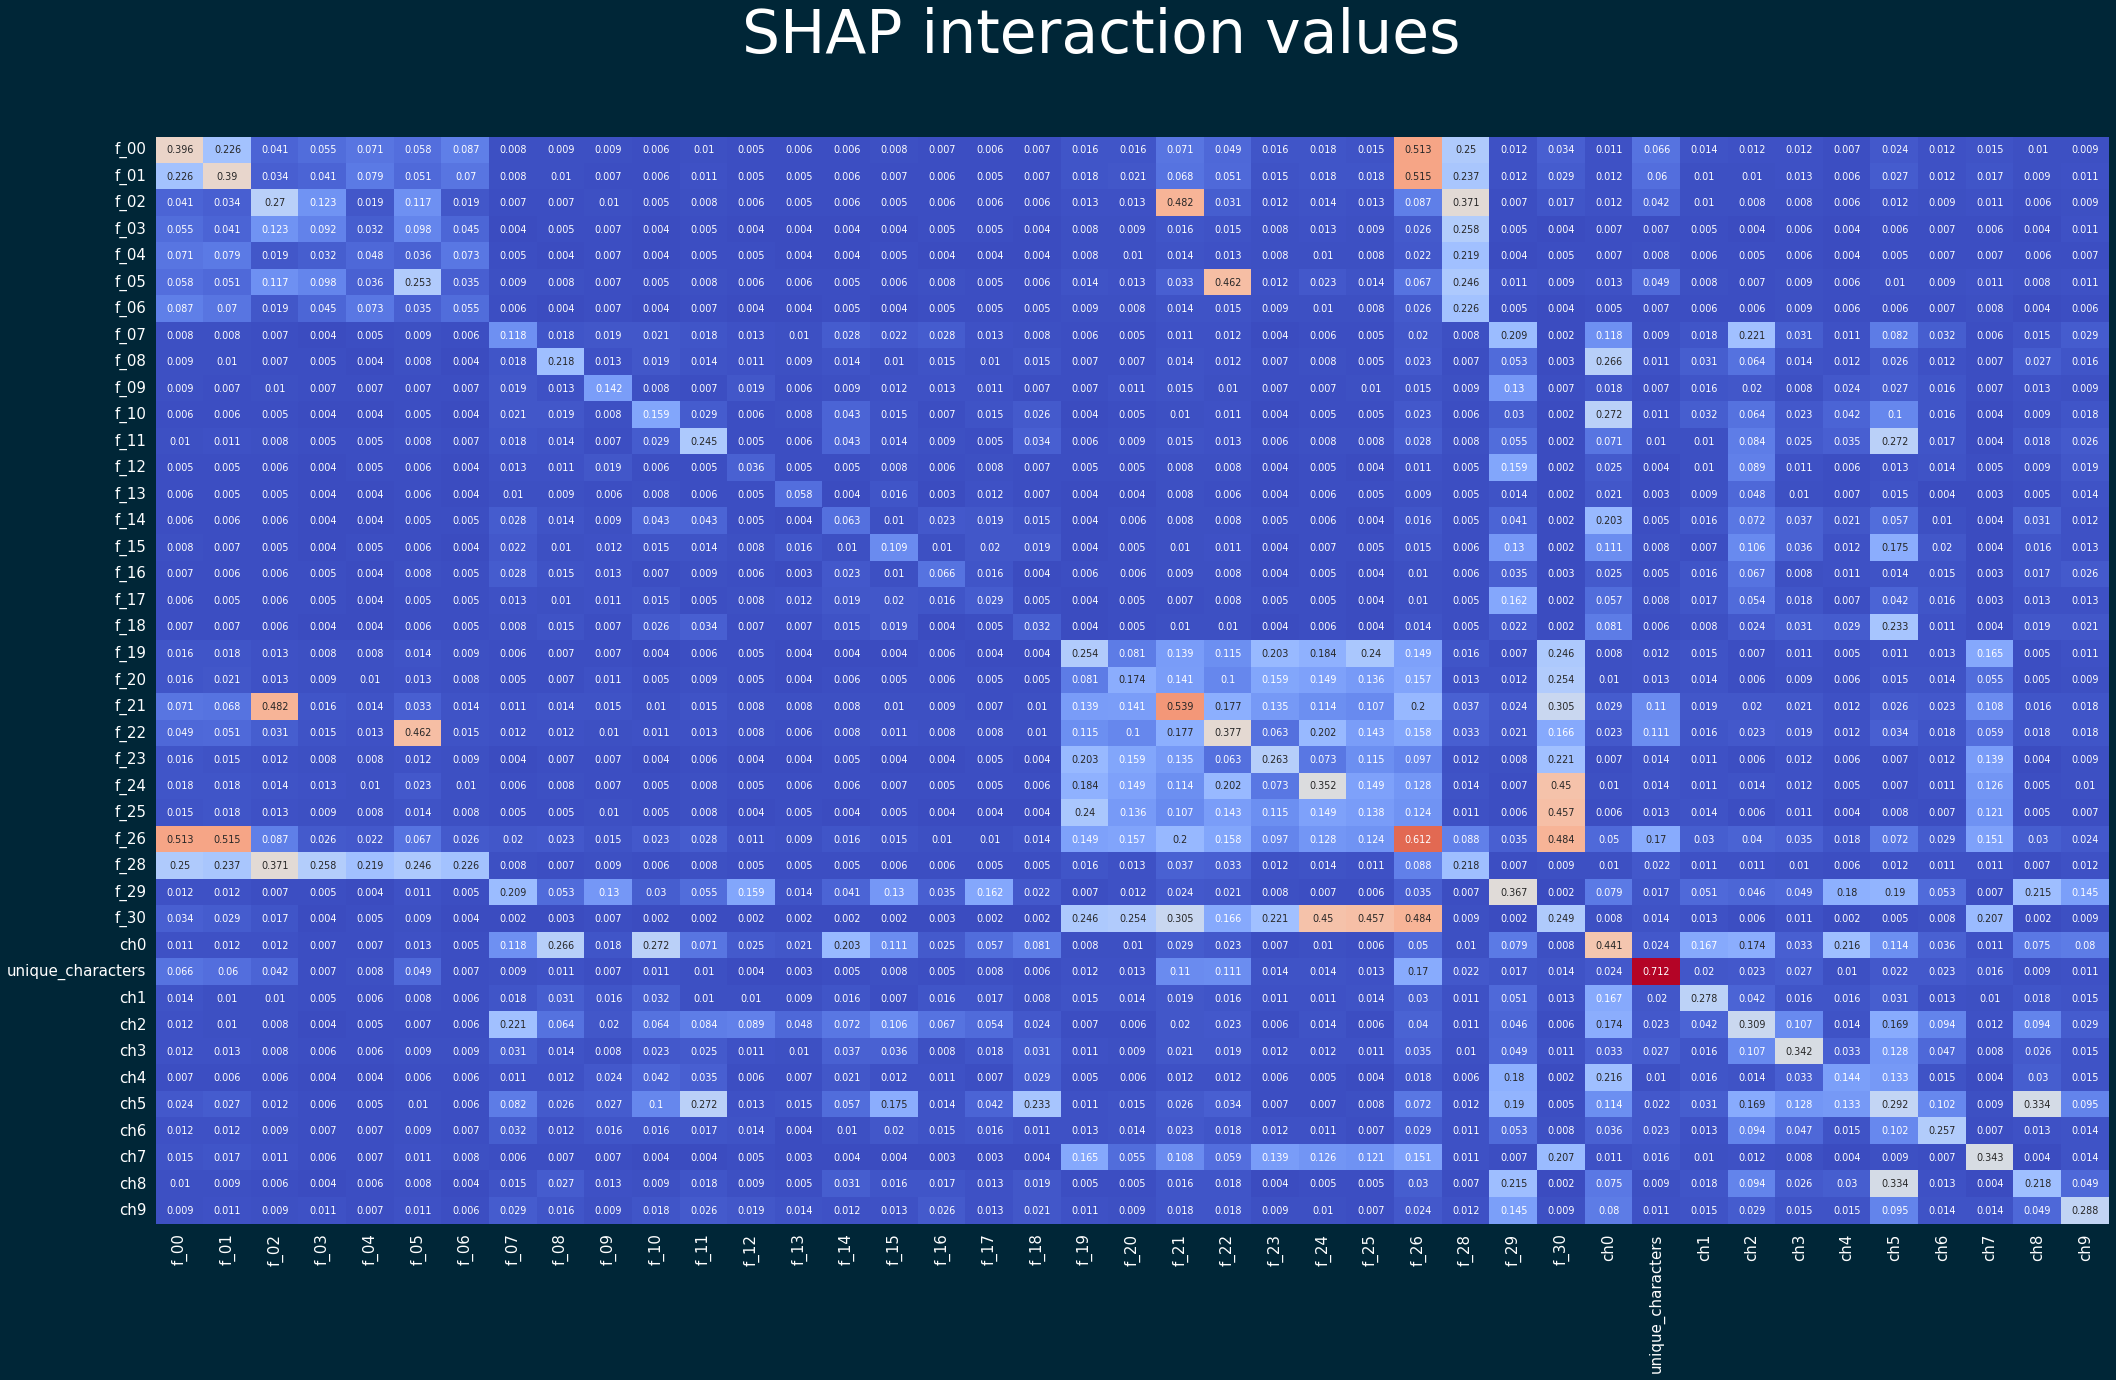

In [29]:
# Get absolute mean of matrices
mean_shap = np.abs(shap_interaction).mean(0)
df = pd.DataFrame(mean_shap, index=X.columns, columns=X.columns)

# times off diagonal by 2
df.where(df.values == np.diagonal(df),df.values*2, inplace=True)

# display 
fig = plt.figure(figsize=(35, 20), facecolor='#002637', edgecolor='r')
ax = fig.add_subplot()
sns.heatmap(df.round(decimals=3), cmap='coolwarm', annot=True, fmt='.6g', cbar=False, ax=ax, )
ax.tick_params(axis='x', colors='w', labelsize=15, rotation=90)
ax.tick_params(axis='y', colors='w', labelsize=15)

plt.suptitle("SHAP interaction values", color="white", fontsize=60, y=0.97)
plt.yticks(rotation=0) 
plt.show()

💡 **INSIGHTS**
- For instance we can see that the main effect is large for features `f_21` (`0.539`) , `f_26` (`0.612`) and `unique_characters`(`0.712`). This tells us that these features tend to have large positive or negative main effects. In other words, these features tend to have a significant impact on the model’s predictions. 
- Similarly, we can see that interaction effects for (`f_00`, `f_26`) --> (`0.513`) and (`f_02`, `f_21`) --> (`0.482`) are significant. These are just some examples.



**Step2: Feature interaction analysis**

So, now that we have calcuated the average (main/interaction)effect of features at global level it is interseting to deep dive into features that show large interaction effects at global level. We can use utilize the `dependence` plot to better understand the nature of the interactions. For the sake of demonstration I will be focusing on `f_02` & `f_21` and `f_24` & `f_30` interaction effects at the local level.

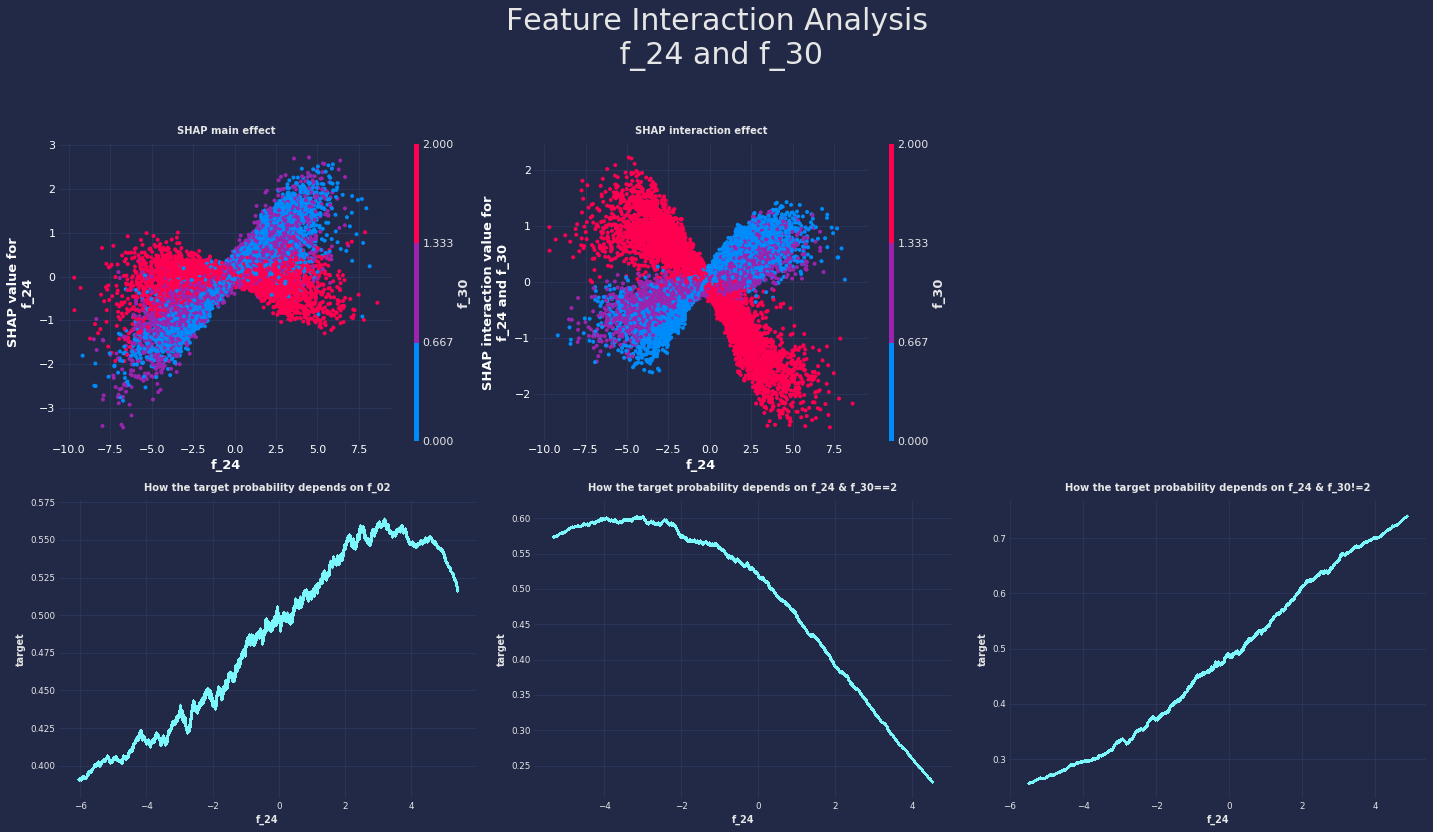

In [17]:
#plot feature interaction
def plot_feature_interaction(f1, f2):
    # dependence plot
    fig = plt.figure(tight_layout=True, figsize=(20,10))
    spec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)


    ax0 = fig.add_subplot(spec[0, 0])
    minv, maxv = np.percentile(X_sampled, [1, 99])
    shap.dependence_plot(f1, shap_values[1], X_sampled, display_features=X_sampled, interaction_index=f2, ax=ax0, show=False)
    ax0.yaxis.label.set_color('white')          #setting up Y-axis label color to blue
    ax0.xaxis.label.set_color('white')          #setting up Y-axis label color to blue
    ax0.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
    ax0.tick_params(axis='y', colors='white')    #setting up X-axis tick color to red
    ax0.set_title(f'SHAP main effect', fontsize=10)

    ax1 = fig.add_subplot(spec[0, 1])
    shap.dependence_plot((f1, f2), shap_interaction, X_sampled, display_features=X_sampled, ax=ax1, axis_color='w', show=False)
    ax1.yaxis.label.set_color('white')          #setting up Y-axis label color to blue
    ax1.xaxis.label.set_color('white')          #setting up Y-axis label color to blue
    ax1.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
    ax1.tick_params(axis='y', colors='white')    #setting up X-axis tick color to red
    ax1.set_title(f'SHAP interaction effect', fontsize=10)


    temp = pd.DataFrame({f1: train_raw[f1].values,
                    'target': train_raw.target.values})
    temp = temp.sort_values(f1)
    temp.reset_index(inplace=True)
    
    ax3 = fig.add_subplot(spec[1, 0])
    sns.scatterplot(x=temp[f1], y=temp.target.rolling(15000, center=True).mean(), data=temp, ax=ax3, s=2)
    ax3.set_title('How the target probability depends on f_02', fontsize=10)

    temp = pd.DataFrame({f1: train_raw.loc[train_raw["f_30"]==2,f1].values,
                    'target': train_raw.loc[train_raw["f_30"]==2,'target'].values})
    temp = temp.sort_values(f1)
    temp.reset_index(inplace=True)
    
    ax4 = fig.add_subplot(spec[1, 1])
    sns.scatterplot(x=temp[f1], y=temp.target.rolling(15000, center=True).mean(), data=temp, ax=ax4, s=2)
    ax4.set_title('How the target probability depends on f_24 & f_30==2', fontsize=10)


    temp = pd.DataFrame({f1: train_raw.loc[train_raw["f_30"]!=2,f1].values,
                    'target': train_raw.loc[train_raw["f_30"]!=2,'target'].values})
    temp = temp.sort_values(f1)
    temp.reset_index(inplace=True)
    
    ax5 = fig.add_subplot(spec[1, 2])
    sns.scatterplot(x=temp[f1], y=temp.target.rolling(15000, center=True).mean(), data=temp, ax=ax5, s=2)
    ax5.set_title('How the target probability depends on f_24 & f_30!=2', fontsize=10)
    
    plt.suptitle("Feature Interaction Analysis\n f_24 and f_30", fontsize=30, y=1.15)
    fig.tight_layout()

    plt.show()

plt.style.use("cyberpunk")

f1='f_24'
f2='f_30'
plot_feature_interaction(f1, f2)

💡 **INSIGHTS**
- From the first plot one can conclude that for `f_30 == 2` main SHAP effect of `f_24` increases for the predictions as `f_24` gets larger.
- From the second plot one can conlcude that for `f_30 == 2` the interaction effect between `f_30` & `f_24` decreases as `f_24` get larger. The opposite is true for `f_30 != 2`.
- The third plot indicates that as `f_24` gets larger the probability for `state==1` increases(see [AmbrosM](https://www.kaggle.com/code/ambrosm/tpsmay22-eda-which-makes-sense)). The fourth and fifth plot are the same as third plot but they are conditioned on `f_30==2` and `f_30!=2`. The results are clearly different.

Lets take one more example. Based on SHAP feature interactions heatmap `f_02` & `f_21` interactions effect which is `0.482` is larger than the main effect of `f_02` which is `0.27`. Lets deep dive into the local level effects.

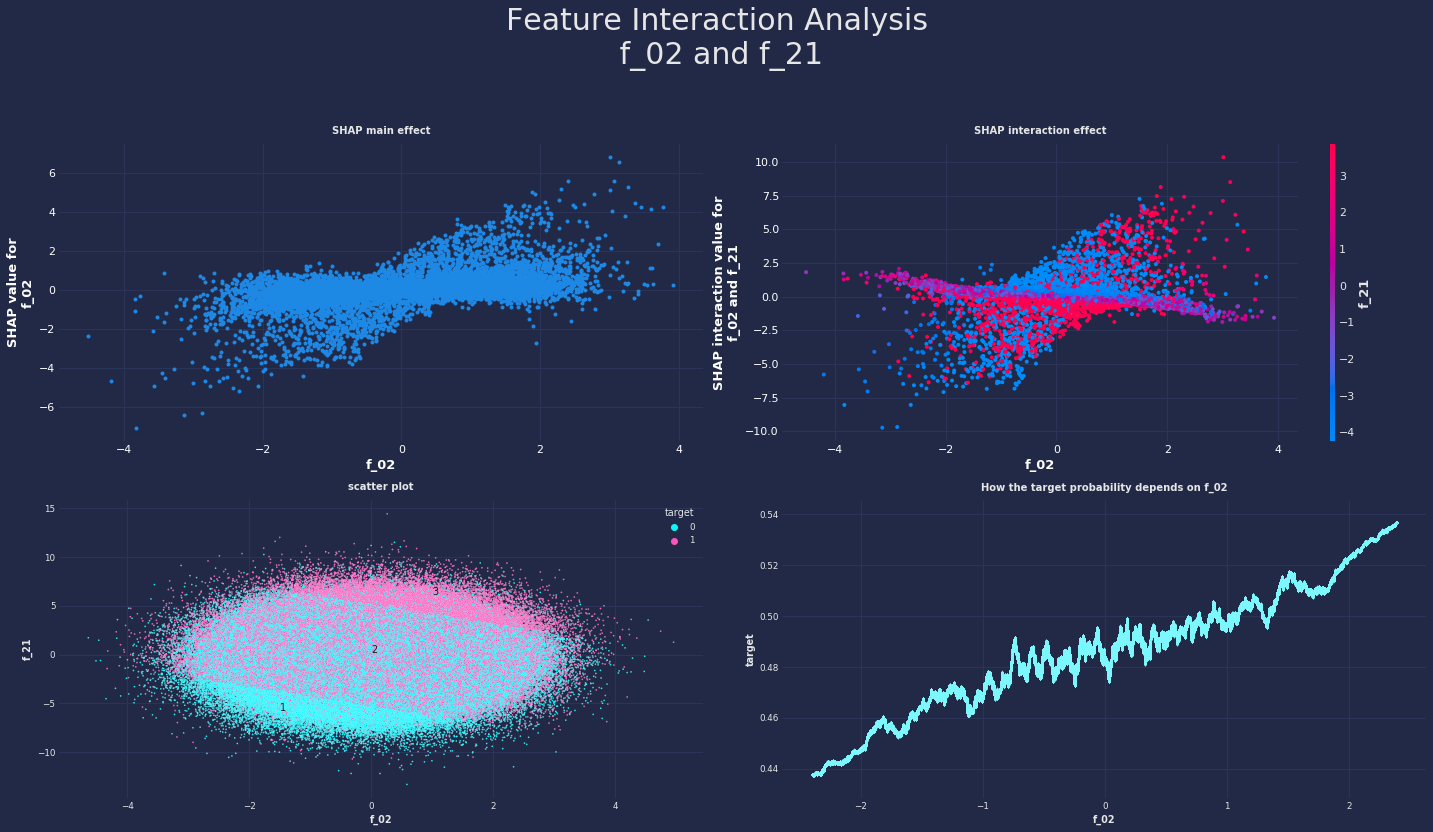

In [18]:
#plot function
plt.style.use("cyberpunk")

def plot_feature_interaction(f1, f2):
    # dependence plot
    fig = plt.figure(tight_layout=True, figsize=(20,10))
    spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)


    ax0 = fig.add_subplot(spec[0, 0])
    shap.dependence_plot(f1, shap_values[1], X_sampled, display_features=X_sampled, interaction_index=None, ax=ax0, show=False)
    ax0.yaxis.label.set_color('white')          #setting up Y-axis label color to blue
    ax0.xaxis.label.set_color('white')          #setting up Y-axis label color to blue
    ax0.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
    ax0.tick_params(axis='y', colors='white')    #setting up X-axis tick color to red
    ax0.set_title(f'SHAP main effect', fontsize=10)

    ax1 = fig.add_subplot(spec[0, 1])
    shap.dependence_plot((f1, f2), shap_interaction, X_sampled, display_features=X_sampled, ax=ax1, axis_color='w', show=False)
    ax1.yaxis.label.set_color('white')          #setting up Y-axis label color to blue
    ax1.xaxis.label.set_color('white')          #setting up Y-axis label color to blue
    ax1.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
    ax1.tick_params(axis='y', colors='white')    #setting up X-axis tick color to red
    ax1.set_title(f'SHAP interaction effect', fontsize=10)

    ax2 = fig.add_subplot(spec[1, 0])
    sns.scatterplot(x=f1, y=f2, data=train_raw, hue="target", ax=ax2, s=2)
    ax2.text(-1.5, -5, "1", fontsize=18, verticalalignment='top', rotation="horizontal", color="k", fontproperties="smallcaps")
    ax2.text(0, 1, "2", fontsize=18, verticalalignment='top', rotation="horizontal", color="k", fontproperties="smallcaps")
    ax2.text(1, 7, "3", fontsize=18, verticalalignment='top', rotation="horizontal", color="k", fontproperties="smallcaps")

    ax2.set_title(f'scatter plot', fontsize=10)

    temp = pd.DataFrame({f1: train_raw[f1].values,'target': train_raw.target.values})
    temp = temp.sort_values(f1)
    temp.reset_index(inplace=True)
    
    ax3 = fig.add_subplot(spec[1, 1])
    sns.scatterplot(x=temp[f1], y=temp.target.rolling(15000, center=True).mean(), data=temp, ax=ax3, s=2)
    ax3.set_title('How the target probability depends on f_02', fontsize=10)
    
    plt.suptitle("Feature Interaction Analysis\n f_02 and f_21", fontsize=30, y=1.15)
    plt.show()

f1='f_02'
f2='f_21'
plot_feature_interaction(f1, f2)

💡 **INSIGHTS**
- From the first plot one can conclude that as `f_02` increases SHAP effect gets larger on the predictions.
- The third plot is very interesting. We can clearly see that there is no correlation between `f_02` and `f_21` but there is an interaction with the target. Based on the `target` we can divide the plot in to 3 different regions.

**Step3: Feature engineering**


To be continued....

<a id="3"></a>
<div class="h2">References</div>

### Domain Knowledge References

    
  1.https://github.com/slundberg/shap/blob/master/notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.ipynb

### Kaggle Kernels for Inspiration
1.https://www.kaggle.com/code/ambrosm/tpsmay22-eda-which-makes-sense
